In [2]:
import numpy as np
import torch
from transformers import *
from sklearn.cluster import KMeans
import time
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:

train_embeddings = {}
test_embeddings = {}
train_embeddings['sents'] = np.load('train/sents.npy')
train_embeddings['vectors'] = np.load('train/vectors.npy')
train_embeddings['labels'] = np.load('train/labels.npy')
test_embeddings['sents'] = np.load('test/sents.npy')
test_embeddings['vectors'] = np.load('test/vectors.npy')
test_embeddings['labels'] = np.load('test/labels.npy')

In [34]:
LABELS = ['it', 'koran', 'law', 'medical', 'subtitles']
N_CLUSTERS = 5
def kmeans(train_data, num_clusters=5):
    model = KMeans(n_clusters=num_clusters,
                   max_iter=250,
                   random_state=1,
                   verbose=1)
    
    model.fit(train_data)
    return model


def get_predictions(model, test_data):
    return model.predict(test_data)


def assign_labels_to_clusters(true_labels, predictions, num_clusters=5):
    cluster_assignment = {}
    true_count = 0
    total = 0
    for k in range(num_clusters):
        count = [0] * 5
        for i, pred in enumerate(predictions):
            if pred == k:
                count[LABELS.index(true_labels[i])] += 1
        max_count = max(count)
        total_count = sum(count)
        cluster_assignment[k] = (LABELS[count.index(max_count)], max_count, total_count)
        true_count += max_count
        total += total_count
    acc = true_count / total
    return cluster_assignment, acc


def calc_test_accuracy(true_labels, predictions, cluster_assignment):
    total = 0
    true_count = 0
    for i, pred in enumerate(predictions):
        if cluster_assignment[pred][0] == true_labels[i]:
            true_count +=1
        total += 1
    return true_count / total

In [5]:
start = time.time()
model = kmeans(train_embeddings['vectors'], N_CLUSTERS)
end  = time.time()
print(f"Time taken to converge: {(end-start) / 3600} hrs.")

Initialization complete
Iteration 0, inertia 19281336.0
Iteration 1, inertia 12072143.0
Iteration 2, inertia 11906313.0
Iteration 3, inertia 11825630.0
Iteration 4, inertia 11774386.0
Iteration 5, inertia 11736304.0
Iteration 6, inertia 11709245.0
Iteration 7, inertia 11690933.0
Iteration 8, inertia 11678739.0
Iteration 9, inertia 11671208.0
Iteration 10, inertia 11665934.0
Iteration 11, inertia 11660886.0
Iteration 12, inertia 11654773.0
Iteration 13, inertia 11645577.0
Iteration 14, inertia 11628302.0
Iteration 15, inertia 11595853.0
Iteration 16, inertia 11547450.0
Iteration 17, inertia 11530277.0
Iteration 18, inertia 11525886.0
Iteration 19, inertia 11523907.0
Iteration 20, inertia 11522811.0
Iteration 21, inertia 11522135.0
Iteration 22, inertia 11521682.0
Iteration 23, inertia 11521392.0
Iteration 24, inertia 11521208.0
Iteration 25, inertia 11521055.0
Iteration 26, inertia 11520959.0
Iteration 27, inertia 11520873.0
Iteration 28, inertia 11520810.0
Iteration 29, inertia 1152074

Iteration 16, inertia 11510533.0
Iteration 17, inertia 11509454.0
Iteration 18, inertia 11508597.0
Iteration 19, inertia 11507878.0
Iteration 20, inertia 11507263.0
Iteration 21, inertia 11506710.0
Iteration 22, inertia 11506240.0
Iteration 23, inertia 11505865.0
Iteration 24, inertia 11505546.0
Iteration 25, inertia 11505244.0
Iteration 26, inertia 11504948.0
Iteration 27, inertia 11504697.0
Iteration 28, inertia 11504472.0
Iteration 29, inertia 11504265.0
Iteration 30, inertia 11504077.0
Iteration 31, inertia 11503897.0
Iteration 32, inertia 11503731.0
Iteration 33, inertia 11503565.0
Iteration 34, inertia 11503413.0
Iteration 35, inertia 11503300.0
Iteration 36, inertia 11503169.0
Iteration 37, inertia 11503048.0
Iteration 38, inertia 11502963.0
Iteration 39, inertia 11502870.0
Iteration 40, inertia 11502769.0
Iteration 41, inertia 11502672.0
Iteration 42, inertia 11502560.0
Iteration 43, inertia 11502438.0
Iteration 44, inertia 11502306.0
Iteration 45, inertia 11502176.0
Iteration 

Iteration 49, inertia 11546915.0
Iteration 50, inertia 11545000.0
Iteration 51, inertia 11542706.0
Iteration 52, inertia 11539969.0
Iteration 53, inertia 11537067.0
Iteration 54, inertia 11534162.0
Iteration 55, inertia 11531433.0
Iteration 56, inertia 11528809.0
Iteration 57, inertia 11526473.0
Iteration 58, inertia 11524222.0
Iteration 59, inertia 11522032.0
Iteration 60, inertia 11519733.0
Iteration 61, inertia 11517341.0
Iteration 62, inertia 11514914.0
Iteration 63, inertia 11512694.0
Iteration 64, inertia 11510696.0
Iteration 65, inertia 11508993.0
Iteration 66, inertia 11507640.0
Iteration 67, inertia 11506593.0
Iteration 68, inertia 11505830.0
Iteration 69, inertia 11505272.0
Iteration 70, inertia 11504829.0
Iteration 71, inertia 11504459.0
Iteration 72, inertia 11504205.0
Iteration 73, inertia 11503993.0
Iteration 74, inertia 11503834.0
Iteration 75, inertia 11503707.0
Iteration 76, inertia 11503609.0
Iteration 77, inertia 11503524.0
Iteration 78, inertia 11503462.0
Iteration 

Iteration 55, inertia 11527953.0
Iteration 56, inertia 11527392.0
Iteration 57, inertia 11526780.0
Iteration 58, inertia 11526138.0
Iteration 59, inertia 11525430.0
Iteration 60, inertia 11524604.0
Iteration 61, inertia 11523632.0
Iteration 62, inertia 11522440.0
Iteration 63, inertia 11521085.0
Iteration 64, inertia 11519564.0
Iteration 65, inertia 11517983.0
Iteration 66, inertia 11516385.0
Iteration 67, inertia 11514716.0
Iteration 68, inertia 11512860.0
Iteration 69, inertia 11511115.0
Iteration 70, inertia 11509644.0
Iteration 71, inertia 11508433.0
Iteration 72, inertia 11507522.0
Iteration 73, inertia 11506987.0
Iteration 74, inertia 11506683.0
Iteration 75, inertia 11506528.0
Iteration 76, inertia 11506441.0
Iteration 77, inertia 11506394.0
Iteration 78, inertia 11506374.0
Iteration 79, inertia 11506352.0
Iteration 80, inertia 11506347.0
Iteration 81, inertia 11506330.0
Iteration 82, inertia 11506338.0
Iteration 83, inertia 11506346.0
Iteration 84, inertia 11506345.0
Iteration 

In [24]:
train_pred = get_predictions(model, train_embeddings['vectors'])
cluster_assignment, accuracy = assign_labels_to_clusters(train_embeddings['labels'], train_pred, N_CLUSTERS)
print(f"Train accuracy is {accuracy:.4f}")

test_pred = get_predictions(model, test_embeddings['vectors'])
test_accuracy = calc_test_accuracy(test_embeddings['labels'], test_pred, cluster_assignment)
print(f"Test accuracy is {test_accuracy:.4f}")

np.save('test_pred_kmeans_k10_distilBERT.npy', test_pred)

Train accuracy is 0.8476
Test accuracy is 0.8605


In [14]:
for k in range(NUM_CLUSTERS):
    print(f'Cluster-{k+1} | label: {cluster_assignment[k][0]} | Purity: {cluster_assignment[k][1]/cluster_assignment[k][2]}')

Cluster-1 | label: law | Purity: 0.8672540257988365
Cluster-2 | label: medical | Purity: 0.9448499812141056
Cluster-3 | label: koran | Purity: 0.6069012420803952
Cluster-4 | label: medical | Purity: 0.559619631027851
Cluster-5 | label: it | Purity: 0.9731438992822685
Cluster-6 | label: subtitles | Purity: 0.9705025871405079
Cluster-7 | label: it | Purity: 0.7493186430849521
Cluster-8 | label: medical | Purity: 0.9865052651082358
Cluster-9 | label: it | Purity: 0.4826408125577101
Cluster-10 | label: law | Purity: 0.9890931890756915


In [17]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

tsne = TSNE(n_components=2, verbose=1, random_state=1)
z = tsne.fit_transform(test_embeddings['vectors'])

/opt/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.014s...
[t-SNE] Computed neighbors for 10000 samples in 3.154s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.272582
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.066025
[t-SNE] KL divergence after 1000 iterations: 2.215315


<AxesSubplot:xlabel='comp-1', ylabel='comp-2'>

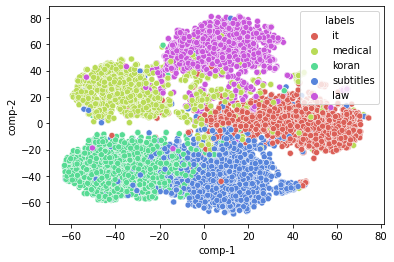

In [32]:
df = pd.DataFrame()
df["labels"] = test_embeddings['labels']
df["clusters"] = [cluster_assignment[pred][0] for pred in test_pred]
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]
sns.scatterplot(data=df, x="comp-1", y="comp-2", hue="labels", palette=sns.color_palette("hls", 5))

<AxesSubplot:xlabel='comp-1', ylabel='comp-2'>

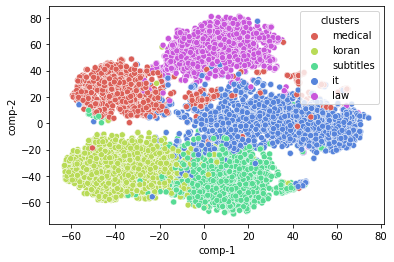

In [36]:
sns.scatterplot(data=df, x="comp-1", y="comp-2", hue="clusters", palette=sns.color_palette("hls", 5))